Код данного ноутбука решает задачу минимизации изломов для прямоугольных вложений двусвязных планарных графов, степени вершин которого принимают значения 2,3,4.
Код основан на следующем алгоритме:
Tamassia, Roberto (1987), "On embedding a graph in the grid with the minimum number of bends", SIAM Journal on Computing, 16 (3): 421–444

Автор Ноутбука: Садыков Ринат


Реализация класса "Сеть", для которой в последствии будет решаться задача поиска цикруляции минимальной стоимости. В данном варианте задачи у каждого ребра есть минимальный поток, максимальный поток, а также стоимость.

In [2]:
class Edge:
    def __init__(self, v_from, v_to, low, cap, cost, idn = 0):
        self.v_from = v_from
        self.v_to = v_to
        self.low = low
        self.cap = cap
        self.cost = cost
        self.flow = 0
        self.idn = idn

class Net:
    def __init__(self):
        self.edges = []
        self.vertex = []
    def AddVertex(self):
        self.vertex.append(len(self.vertex))
        self.edges.append([])
        return len(self.vertex)-1
    def AddEdge(self, v_from, v_to, low, cap, cost, idn = 0):
        edge = Edge(v_from, v_to, low, cap, cost, idn)
        self.edges[v_from].append(edge)
        
infty = 1000000

Данная функция решает задачу поиска пути в остаточной сети

In [3]:
def FindPath(net, start, finish):
    n = len(net.vertex)
    queue = [start]
    used = [False for i in range(n)]
    parent = [0 for i in range(n)]
    used[start] = True
    parent[start] = -1
    while (len(queue) > 0):
        vertex = queue.pop(0)
        for edge in net.edges[vertex]:
            to = edge.v_to
            if (not used[to]) and edge.cap > edge.flow:
                used[to] = True
                queue.append(to)
                parent[to] = edge
    if not used[finish]:
        return 'No path'
    else:
        path = []
        v = finish
        while v != start:
            path.append(parent[v])
            v = parent[v].v_from
        path.reverse()
        return path

Данная функция ищет удовлетворяющую ограничением циркуляцию сети

In [4]:
def FindCirculation(net):
    is_ok = False
    while not is_ok:
        is_ok = True
        for vertex in net.vertex:
            for edge in net.edges[vertex]:
                if edge.low > edge.flow:
                    is_ok = False
                    treshold = edge.low - edge.flow
                    path = FindPath(net, edge.v_to, edge.v_from)
                    min_flow = infty
                    for e in path:
                        min_flow = min(min_flow, e.cap - e.flow)
                    add_flow = min(min_flow, treshold)
                    edge.flow += add_flow
                    for e in path:
                        e.flow += add_flow
                    


Данная функция ищет циркуляцию минимальной стоимости. Для начала ищется любая циркуляция, затем выполныется серия релаксаций:
С помощью алгоритма Форда-Беллмана ищется цикл, проталкивание по которому единицы потока уменьшает стоимость циркуляции. Если таких циклов нет, то циркуляция оптимальна.

In [5]:
def FindMinCostCirculation(net):
    FindCirculation(net)
    n = len(net.vertex)
    for root in range(n):
        cycle = True
        while(cycle):
            dist = [infty for i in range(n)]
            dist[root]= 0
            parent = [-1 for i in range(n)]
            parent_direction = [True for i in range(n)]
            for i in range(n):
                v_rel = -1
                for v in net.edges:
                    for edge in v:
                        if edge.flow < edge.cap:
                            if dist[edge.v_from] < infty:
                                if dist[edge.v_to] > dist[edge.v_from] + edge.cost:
                                    dist[edge.v_to] = max(-infty, dist[edge.v_from] + edge.cost)
                                    parent[edge.v_to] = edge
                                    parent_direction[edge.v_to] = True
                                    v_rel = edge.v_to
                        if edge.flow > edge.low:
                            if dist[edge.v_to] < infty:
                                if dist[edge.v_from] > dist[edge.v_to] - edge.cost:
                                    dist[edge.v_from] = max(-infty, dist[edge.v_to] - edge.cost)
                                    parent[edge.v_from] = edge
                                    parent_direction[edge.v_from] = False
                                    v_rel = edge.v_from
            cycle = (v_rel != -1)
            if cycle:
                v = v_rel
                for i in range(n):
                    if parent_direction[v]:
                        v = parent[v].v_from
                    else:
                        v = parent[v].v_to
                path = []
                path_dir = []
                cur = v
                while True:
                    path.append(parent[cur])
                    path_dir.append(parent_direction[cur])
                    if cur == v and len(path) > 1:
                        break
                    if parent_direction[cur]:
                        cur = parent[cur].v_from
                    else:
                        cur = parent[cur].v_to
                path.reverse()
                path_dir.reverse()
                path_dir.pop(0)
                path.pop(0)
                max_flow = infty;
                for i in range(len(path)):
                    if path_dir[i]:
                        max_flow = min(max_flow, path[i].cap - path[i].flow)
                    else:
                        max_flow = min(max_flow, path[i].flow - path[i].low)
                for i in range(len(path)):
                    if path_dir[i]:
                        path[i].flow += max_flow
                    else:
                        path[i].flow -= max_flow

Реализация структуры планарного графа

In [6]:
class PlanarEdge:
    def __init__(self, vertex1, vertex2, idn):
        self.v_from = min(vertex1, vertex2)
        self.v_to = max(vertex1, vertex2)
        self.faces = []
        self.idn = idn
class PlanarFace:
    def __init__(self, vertices, idn):
        self.size = len(vertices) - 1
        self.vertices = vertices
        self.idn = idn
class PlanarGraph:
    def __init__(self, n, edges, faces):
        self.n = n
        self.e = len(edges)
        self.edges = [[] for i in range(n)]
        for edge in edges:
            v_from = min(edge)
            v_to = max(edge)
            self.edges[v_from].append(PlanarEdge(v_from, v_to, len(self.edges)))
        self.faces = []
        for face in faces:
            n_face = PlanarFace(face, len(self.faces))
            self.faces.append(n_face)
            for i in range(len(face) - 1):
                v_from = min(face[i], face[i + 1])
                v_to = max(face[i], face[i + 1])
                for edge in self.edges[v_from]:
                    if edge.v_to == v_to:
                        edge.faces.append(n_face.idn)
                        break
                

Функция построения сети по планарному графу

In [7]:
def CreateNet(graph):
    n = graph.n
    net = Net()
    for i in range(n):
        net.AddVertex()
    f = len(graph.faces)
    for i in range(f):
        net.AddVertex()
    s = net.AddVertex()
    t = net.AddVertex()
    for face in graph.faces:
        for i in range(face.size):
            net.AddEdge(face.vertices[i], face.idn + n, 1, 4, 0)
    for v in graph.edges:
        for edge in v:
            net.AddEdge(edge.faces[0] + n, edge.faces[1] + n, 0, infty, 1, [edge.v_from, edge.v_to])
            net.AddEdge(edge.faces[1] + n, edge.faces[0] + n, 0, infty, 1, [edge.v_from, edge.v_to])
    for i in range(n):
        net.AddEdge(s, i, 4, 4, 0)
    for face in graph.faces:
        if face.idn == 0:
            net.AddEdge(n, t, 2 * face.size + 4, 2 * face.size + 4, 0)
        else:
            net.AddEdge(n + face.idn, t, 2 * face.size - 4, 2 * face.size - 4, 0)
    net.AddEdge(t, s, 0, infty, 0)
    return net

Структура данных для хранения прямоугольного графа

In [8]:
class RectangularEdge:
    def __init__(self, v_from, v_to, faces):
        self.v_from = v_from
        self.v_to = v_to
        self.dir = [0,0]
        self.faces = faces
class RectangularGraph:
    def __init__(self, n, n_bends, edges):
        self.n = n
        self.bends = n_bends
        self.edges = edges
    

    
    

Данная функция по планарному графу вычисляет прямоугольную реализацию, добавляет по вершине на каждый излом ребра и вычисляет направления всех рёбер.

In [9]:
def BuildRectangularGraph(graph):
    n = graph.n
    e = graph.e
    f = 2 - n + e
    net = CreateNet(graph)
    FindMinCostCirculation(net)
    angles = [[0 for i in range (f)] for j in range(n + 4 * e)]
    bends = [[[0 for k in range(f)] for i in range (n + 4 * e)] for j in range(n + 4 * e)]
    face_matrix = [[[] for i in range (n + 4 * e)] for j in range(n + 4 * e)]
    for v in net.edges:
        for edge in v:
            if max(edge.v_from, edge.v_to) >= n + f:
                continue
            elif min(edge.v_from, edge.v_to) < n:
                vertex = min(edge.v_from, edge.v_to)
                face = max(edge.v_from, edge.v_to) - n
                angles[vertex][face] = edge.flow
            else:
                bends[edge.idn[0]][edge.idn[1]][edge.v_from - n] = edge.flow
                for p_edge in graph.edges[edge.idn[0]]:
                    if p_edge.v_to == edge.idn[1]:
                        face_matrix[edge.idn[0]][edge.idn[1]] = p_edge.faces
    new_v_count = 0
    for v in graph.edges:
        for edge in v:
            v_from = edge.v_from
            v_to = edge.v_to
            face1 = edge.faces[0]
            face2 = edge.faces[1]
            v_cur = v_from
            for i in range(bends[v_from][v_to][face1]):
                face_matrix[v_from][v_to] = []
                face_matrix[v_cur][n + new_v_count] = [edge.faces[0], edge.faces[1]]
                angles[n + new_v_count][face1] = 1
                angles[n + new_v_count][face2] = 3
                v_cur = n + new_v_count
                new_v_count += 1
            for i in range(bends[v_from][v_to][face2]):
                face_matrix[v_from][v_to] = []
                face_matrix[v_cur][n + new_v_count] = [edge.faces[0], edge.faces[1]]
                angles[n + new_v_count][face2] = 1
                angles[n + new_v_count][face1] = 3
                v_cur = n + new_v_count
                new_v_count += 1
            if v_cur >= n:
                face_matrix[v_to][v_cur] = [edge.faces[0], edge.faces[1]]
    rec_edges = []
    for i in range(n + 4 * e):
        for j in range(n + 4 * e):
            if face_matrix[i][j] != []:
                rec_edges.append(RectangularEdge(i, j, face_matrix[i][j]))
    rec_edges[0].dir = [1,0]
    all_good = False
    while not all_good:
        all_good = True
        for edge in rec_edges:
            if edge.dir == [0,0]:
                all_good = False
                for done_edge in rec_edges:
                    if done_edge.dir != [0,0]:
                        if edge.v_from == done_edge.v_from:
                            if edge.faces[0] == done_edge.faces[0]:
                                edge.faces[0], edge.faces[1] = edge.faces[1], edge.faces[0]
                                if angles[edge.v_from][done_edge.faces[0]] == 1:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                                if angles[edge.v_from][done_edge.faces[0]] == 2:
                                    edge.dir = [-done_edge.dir[0], -done_edge.dir[1]]
                                    break
                                if angles[edge.v_from][done_edge.faces[0]] == 3:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                            if edge.faces[1] == done_edge.faces[0]:
                                if angles[edge.v_from][done_edge.faces[0]] == 1:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                                if angles[edge.v_from][done_edge.faces[0]] == 2:
                                    edge.dir = [-done_edge.dir[0], -done_edge.dir[1]]
                                    break
                                if angles[edge.v_from][done_edge.faces[0]] == 3:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                            if edge.faces[0] == done_edge.faces[1]:
                                if angles[edge.v_from][done_edge.faces[1]] == 1:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                                if angles[edge.v_from][done_edge.faces[1]] == 2:
                                    edge.dir = [-done_edge.dir[0], -done_edge.dir[1]]
                                    break
                                if angles[edge.v_from][done_edge.faces[1]] == 3:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                            if edge.faces[1] == done_edge.faces[1]:
                                edge.faces[0], edge.faces[1] = edge.faces[1], edge.faces[0]
                                if angles[edge.v_from][done_edge.faces[1]] == 1:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                                if angles[edge.v_from][done_edge.faces[1]] == 2:
                                    edge.dir = [-done_edge.dir[0], -done_edge.dir[1]]
                                    break
                                if angles[edge.v_from][done_edge.faces[1]] == 3:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                                    
                                    
                                    
                        if edge.v_to == done_edge.v_from:
                            if edge.faces[0] == done_edge.faces[0]:
                                if angles[edge.v_to][done_edge.faces[0]] == 1:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                                if angles[edge.v_to][done_edge.faces[0]] == 2:
                                    edge.dir = [done_edge.dir[0], done_edge.dir[1]]
                                    break
                                if angles[edge.v_to][done_edge.faces[0]] == 3:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                            if edge.faces[1] == done_edge.faces[0]:
                                edge.faces[0], edge.faces[1] = edge.faces[1], edge.faces[0]
                                if angles[edge.v_to][done_edge.faces[0]] == 1:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                                if angles[edge.v_to][done_edge.faces[0]] == 2:
                                    edge.dir = [done_edge.dir[0], done_edge.dir[1]]
                                    break
                                if angles[edge.v_to][done_edge.faces[0]] == 3:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                            if edge.faces[0] == done_edge.faces[1]:
                                edge.faces[0], edge.faces[1] = edge.faces[1], edge.faces[0]
                                if angles[edge.v_to][done_edge.faces[1]] == 1:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                                if angles[edge.v_to][done_edge.faces[1]] == 2:
                                    edge.dir = [done_edge.dir[0], done_edge.dir[1]]
                                    break
                                if angles[edge.v_to][done_edge.faces[1]] == 3:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                            if edge.faces[1] == done_edge.faces[1]:
                                if angles[edge.v_to][done_edge.faces[1]] == 1:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                                if angles[edge.v_to][done_edge.faces[1]] == 2:
                                    edge.dir = [done_edge.dir[0], done_edge.dir[1]]
                                    break
                                if angles[edge.v_to][done_edge.faces[1]] == 3:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                                    
                                    
                        if edge.v_from == done_edge.v_to:
                            if edge.faces[0] == done_edge.faces[0]:
                                if angles[edge.v_from][done_edge.faces[0]] == 1:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                                if angles[edge.v_from][done_edge.faces[0]] == 2:
                                    edge.dir = [done_edge.dir[0], done_edge.dir[1]]
                                    break
                                if angles[edge.v_from][done_edge.faces[0]] == 3:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                            if edge.faces[1] == done_edge.faces[0]:
                                edge.faces[0], edge.faces[1] = edge.faces[1], edge.faces[0]
                                if angles[edge.v_from][done_edge.faces[0]] == 1:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                                if angles[edge.v_from][done_edge.faces[0]] == 2:
                                    edge.dir = [done_edge.dir[0], done_edge.dir[1]]
                                    break
                                if angles[edge.v_from][done_edge.faces[0]] == 3:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                            if edge.faces[0] == done_edge.faces[1]:
                                edge.faces[0], edge.faces[1] = edge.faces[1], edge.faces[0]
                                if angles[edge.v_from][done_edge.faces[1]] == 1:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                                if angles[edge.v_from][done_edge.faces[1]] == 2:
                                    edge.dir = [done_edge.dir[0], done_edge.dir[1]]
                                    break
                                if angles[edge.v_from][done_edge.faces[1]] == 3:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                            if edge.faces[1] == done_edge.faces[1]:
                                if angles[edge.v_from][done_edge.faces[1]] == 1:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                                if angles[edge.v_from][done_edge.faces[1]] == 2:
                                    edge.dir = [done_edge.dir[0], done_edge.dir[1]]
                                    break
                                if angles[edge.v_from][done_edge.faces[1]] == 3:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                                    
                                    
                        if edge.v_to == done_edge.v_to:
                            if edge.faces[0] == done_edge.faces[0]:
                                edge.faces[0], edge.faces[1] = edge.faces[1], edge.faces[0]
                                if angles[edge.v_to][done_edge.faces[0]] == 1:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                                if angles[edge.v_to][done_edge.faces[0]] == 2:
                                    edge.dir = [-done_edge.dir[0], -done_edge.dir[1]]
                                    break
                                if angles[edge.v_to][done_edge.faces[0]] == 3:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                            if edge.faces[1] == done_edge.faces[0]:
                                if angles[edge.v_to][done_edge.faces[0]] == 1:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                                if angles[edge.v_to][done_edge.faces[0]] == 2:
                                    edge.dir = [-done_edge.dir[0], -done_edge.dir[1]]
                                    break
                                if angles[edge.v_to][done_edge.faces[0]] == 3:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                            if edge.faces[0] == done_edge.faces[1]:
                                if angles[edge.v_to][done_edge.faces[1]] == 1:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                                if angles[edge.v_to][done_edge.faces[1]] == 2:
                                    edge.dir = [-done_edge.dir[0], -done_edge.dir[1]]
                                    break
                                if angles[edge.v_to][done_edge.faces[1]] == 3:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                            if edge.faces[1] == done_edge.faces[1]:
                                edge.faces[0], edge.faces[1] = edge.faces[1], edge.faces[0]
                                if angles[edge.v_to][done_edge.faces[1]] == 1:
                                    edge.dir = [-done_edge.dir[1], done_edge.dir[0]]
                                    break
                                if angles[edge.v_to][done_edge.faces[1]] == 2:
                                    edge.dir = [-done_edge.dir[0], -done_edge.dir[1]]
                                    break
                                if angles[edge.v_to][done_edge.faces[1]] == 3:
                                    edge.dir = [done_edge.dir[1], -done_edge.dir[0]]
                                    break
                    
                                    
    return RectangularGraph(n, new_v_count, rec_edges)
                        

Данная функция по прямоугольному графу с заданными направлениями рёбер находит координаты вершин

In [56]:
def FindCoords(rec_graph):
    x_groups = [{i} for i in range(rec_graph.n + rec_graph.bends)]
    max_coms = [{i} for i in range(rec_graph.n + rec_graph.bends)]
    for edge in rec_graph.edges:
        if edge.dir[0] == 0:
            new_set = x_groups[edge.v_from].union(x_groups[edge.v_to])
            max_coms.remove(x_groups[edge.v_from])
            max_coms.remove(x_groups[edge.v_to])
            max_coms.append(new_set)
            x_groups[edge.v_from] = new_set
            x_groups[edge.v_to] = new_set
    P = []
    n_comp = len(max_coms)
    A = [set() for i in range(n_comp)]
    for edge in rec_graph.edges:
        if edge.dir[1] == 0:
            v_from = edge.v_from
            v_to = edge.v_to
            for c in range(n_comp):
                if v_from in max_coms[c]:
                    c_from = c
                if v_to in max_coms[c]:
                    c_to = c
            if edge.dir[0] == 1:
                A[c_to].add(c_from)
            else:
                A[c_from].add(c_to)
    while len(P) < n_comp:
        for v in range(n_comp):
            if len(A[v]) == 0 and v not in P:
                P.append(v)
                for u in range(n_comp):
                    A[u].discard(v)
    x = [0 for i in range(rec_graph.n + rec_graph.bends)]
    for i in range(n_comp):
        for v in max_coms[P[i]]:
            x[v] = i
            
            
    y_groups = [{i} for i in range(rec_graph.n + rec_graph.bends)]
    max_coms = [{i} for i in range(rec_graph.n + rec_graph.bends)]
    for edge in rec_graph.edges:
        if edge.dir[1] == 0:
            new_set = y_groups[edge.v_from].union(y_groups[edge.v_to])
            max_coms.remove(y_groups[edge.v_from])
            max_coms.remove(y_groups[edge.v_to])
            max_coms.append(new_set)
            y_groups[edge.v_from] = new_set
            y_groups[edge.v_to] = new_set
    P = []
    n_comp = len(max_coms)
    A = [set() for i in range(n_comp)]
    for edge in rec_graph.edges:
        if edge.dir[0] == 0:
            v_from = edge.v_from
            v_to = edge.v_to
            for c in range(n_comp):
                if v_from in max_coms[c]:
                    c_from = c
                if v_to in max_coms[c]:
                    c_to = c
            if edge.dir[1] == 1:
                A[c_to].add(c_from)
            else:
                A[c_from].add(c_to)
    while len(P) < n_comp:
        for v in range(n_comp):
            if len(A[v]) == 0 and v not in P:
                P.append(v)
                for u in range(n_comp):
                    A[u].discard(v)
    y = [0 for i in range(rec_graph.n + rec_graph.bends)]
    for i in range(n_comp):
        for v in max_coms[P[i]]:
            y[v] = i
    return x,y
    
    

            

Функция, рисующая граф

In [53]:
def Draw(n, x, y, edges):
    import matplotlib.pyplot as plt
    %matplotlib inline
    eps = 0.1
    for edge in edges:
        v1 = edge.v_from
        v2 = edge.v_to
        plt.plot((x[v1],x[v2]), (y[v1],y[v2]), color = 'black')
    for i in range(n):
        plt.scatter(x[i], y[i], c = 'black', s = 100)
        plt.text(x[i]+eps, y[i]+eps, str(i))
    plt.axis('off')
    plt.show()
    

Функция чтения данных. Формат данных в файле: первая строчка содержит количество вершин n и количество рёбер e плоского графа.
следующие e строчек содержат рёбра графа(вершинами являются числа от 0 до n-1). Следующие f = 2 - n + e строчек содержат информацию о гранях графа: перечисляются последовательно вершины границы грани. первая и последняя вершины совпадают. Первой указана информация о внешней грани.

In [11]:
def Read(path):
    file = open(path)
    n, e = list(map(int, file.readline().split()))
    f = 2 - n + e
    edges = []
    for i in range(e):
        edges.append(list(map(int, file.readline().split())))
    faces = []
    for i in range(f):
        faces.append(list(map(int, file.readline().split())))
    file.close()
    return n, edges, faces

Построение рисунка по информации о графе из файла

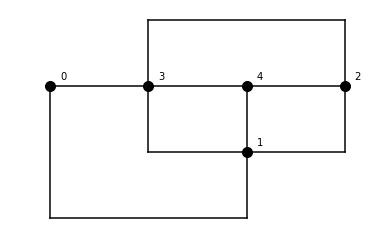

In [59]:
n, edges, faces = Read('./input.txt')
pg = PlanarGraph(n,edges,faces)
rec_graph = BuildRectangularGraph(pg)
edges = rec_graph.edges
x, y = FindCoords(rec_graph)
Draw(n, x, y, edges)
